In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from xgboost import XGBClassifier

In [2]:
# Seed
SEED = 4672  
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## Loading Data

In [3]:
# Loading data
df = pd.read_csv("/kaggle/input/breastcancerdata/breast-cancer.csv")

## Converting Categorical Variables

In [4]:
# Converting categorical variables to numerical ones
categorical_columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

## Data Scaling

In [5]:
x = df.drop(columns=["target"])
y = df["target"]

# Data Scaling
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

## Train and Test Split

In [6]:
# Train and Test Split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=SEED)

## Class Weights

In [7]:
# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

y_train = np.array(y_train)

## FCNN Model

In [8]:
# FCNN Model
model = Sequential([
    Input(shape=(9,)),
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(16, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 192 (768.00 B)

### FCNN Fit

In [9]:
history = model.fit(x_train, y_train, 
                    validation_data = (x_test, y_test), 
                    epochs = 100, 
                    batch_size = 32, 
                    callbacks = [early_stopping], 
                    class_weight = class_weight_dict)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4358 - loss: 0.8651 - val_accuracy: 0.4138 - val_loss: 0.7881
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4842 - loss: 0.7998 - val_accuracy: 0.5000 - val_loss: 0.7771
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5209 - loss: 0.7758 - val_accuracy: 0.6207 - val_loss: 0.7690
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5218 - loss: 0.7665 - val_accuracy: 0.6034 - val_loss: 0.7615
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5206 - loss: 0.7427 - val_accuracy: 0.6207 - val_loss: 0.7553
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6288 - loss: 0.6865 - val_accuracy: 0.6207 - val_loss: 0.7483
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6603 - loss: 0.7022 - val_accuracy: 0.6379 - val_loss: 0.7428
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6816 - loss: 0.6714 - val_accuracy: 0.6379 - val_loss: 0.7372

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6879 - loss: 0.6813 
Test Doğruluğu: 67.24%


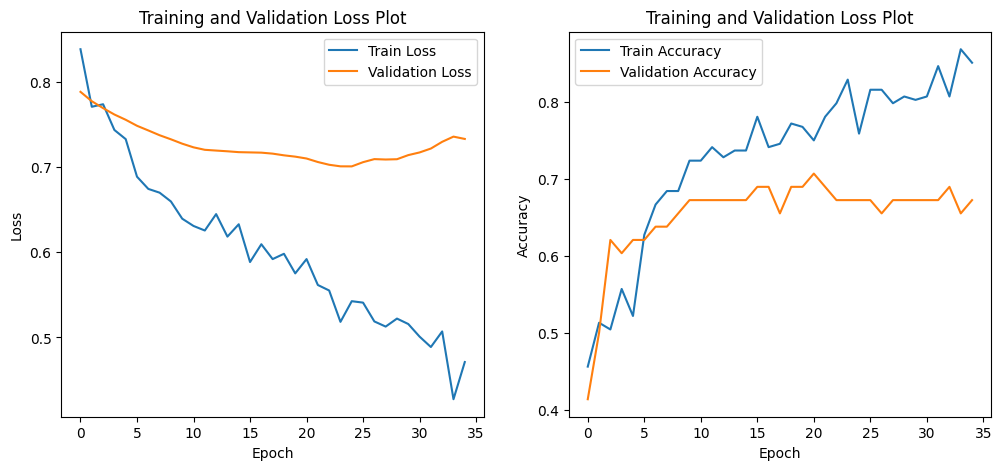

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


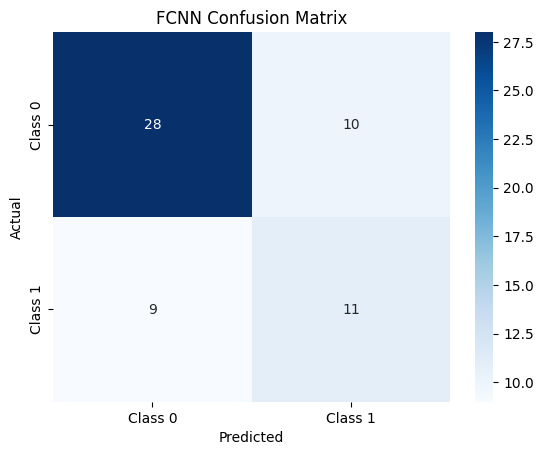

In [10]:
# Model Performance
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Doğruluğu: {test_acc * 100:.2f}%")

# Visualization: Training Process
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Plot')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss Plot')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = (model.predict(x_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("FCNN Confusion Matrix")
plt.show()

## Random Forest

In [11]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=SEED)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 0.6896551724137931
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        38
           1       0.56      0.45      0.50        20

    accuracy                           0.69        58
   macro avg       0.65      0.63      0.64        58
weighted avg       0.68      0.69      0.68        58



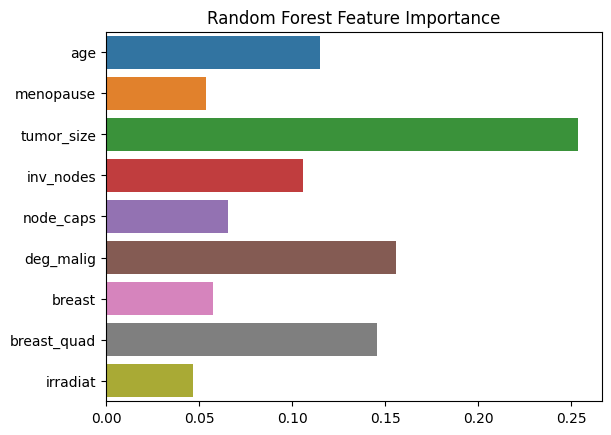

In [12]:
# Feature Importance (Random Forest)
rf_importance = rf_model.feature_importances_
sns.barplot(x=rf_importance, y=x.columns)
plt.title("Random Forest Feature Importance")
plt.show()

## XGBoost Model

In [13]:
# XGBoost Model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=SEED, eval_metric="logloss")
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

XGBoost Accuracy: 0.6551724137931034
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        38
           1       0.50      0.40      0.44        20

    accuracy                           0.66        58
   macro avg       0.61      0.59      0.60        58
weighted avg       0.64      0.66      0.64        58



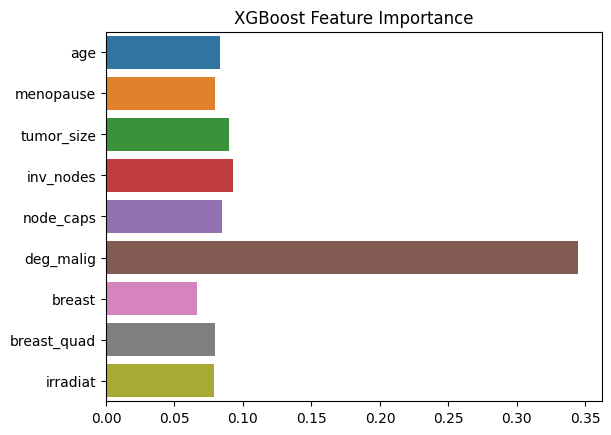

In [14]:
# Feature Importance (XGBoost)
xgb_importance = xgb_model.feature_importances_
sns.barplot(x=xgb_importance, y=x.columns)
plt.title("XGBoost Feature Importance")
plt.show()

## SVM Model

In [15]:
# SVM Model
svm_model = SVC(kernel="rbf", class_weight=class_weight_dict, probability=True, random_state=SEED)
svm_model.fit(x_train, y_train)
svm_pred = svm_model.predict(x_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

SVM Accuracy: 0.603448275862069
              precision    recall  f1-score   support

           0       0.76      0.58      0.66        38
           1       0.45      0.65      0.53        20

    accuracy                           0.60        58
   macro avg       0.60      0.61      0.59        58
weighted avg       0.65      0.60      0.61        58



## ROC-AUC Curves

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


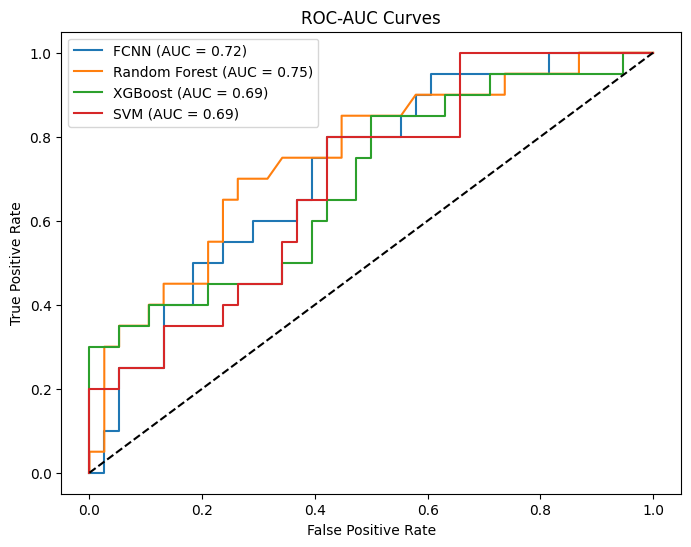

In [16]:
# ROC-AUC Curves
plt.figure(figsize=(8, 6))
models = {
    "FCNN": model.predict(x_test).ravel(),
    "Random Forest": rf_model.predict_proba(x_test)[:, 1],
    "XGBoost": xgb_model.predict_proba(x_test)[:, 1],
    "SVM": svm_model.predict_proba(x_test)[:, 1]
}

for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curves")
plt.legend()
plt.show()